```
                              Assignment: Deep Learning Engineer
                                        Mohit Sharma

mohit.sharma3105@yahoo.com
7999535445

```


# Part 1: Setup

## Install the required packages:
1. TensorFlow
2. NumPy
3. Pillow



In [ ]:
# !pip install tensorflow
# !pip install numpy
# !pip install Pillow

## Import Library

In [47]:
import numpy as np
import tensorflow as tf
import keras 
import cv2
from tqdm import tqdm
import os
import re
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import img_to_array
import math
import tensorflow.keras as K
# vgg net for perceptual loss
from tensorflow.keras.applications.vgg19 import VGG19
import cv2
tf.config.run_functions_eagerly(True)
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import backend as K1
from skimage.metrics import structural_similarity as ssim


import os
import time
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy, MeanAbsoluteError
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Mean
from PIL import Image
from utils.config import config
import os
import tensorflow as tf
import glob
from tensorflow.python.data.experimental import AUTOTUNE
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Add, Lambda , LeakyReLU, Flatten, Dense
from tensorflow.python.keras.layers import PReLU
from tensorflow.python.keras.layers import PReLU

## Div2k Dataset

In [2]:
folder = '/content/drive/MyDrive/im1/'
SIZE = 256
# /content/drive/MyDrive/im1/DIV2K_train_LR_difficult

In [3]:
# To get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

###  Preprocess Dataset for Model: 

In [4]:
## High resolution Image
# defining the size of the image
SIZE = 256
high_img = []
path = folder+ 'DIV2K_train_HR'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
  
      img = cv2.imread(path + '/'+i,1)
      # open cv reads images in BGR format so we have to convert it to RGB
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      #resizing image
      img = cv2.resize(img, (SIZE, SIZE))
      img = img.astype('float32') 

# scaling the pixel values to the range [-1, 1]        
      img = (img-127.5)/127.5 
      high_img.append(img_to_array(img))

100%|██████████| 800/800 [01:57<00:00,  6.81it/s]


In [5]:
## Low resolution Image
low_img = []
path = folder + 'DIV2K_train_LR_difficult'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
 
      img = cv2.imread(path + '/'+i,1)

      #resizing image
      img = cv2.resize(img, (SIZE, SIZE))
      img = img.astype('float32') 
      img = (img-127.5)/127.5
      low_img.append(img_to_array(img))

100%|██████████| 800/800 [00:20<00:00, 38.75it/s]


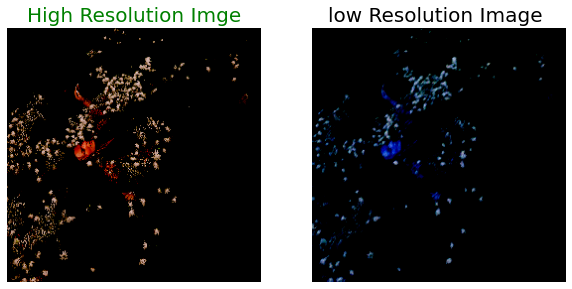

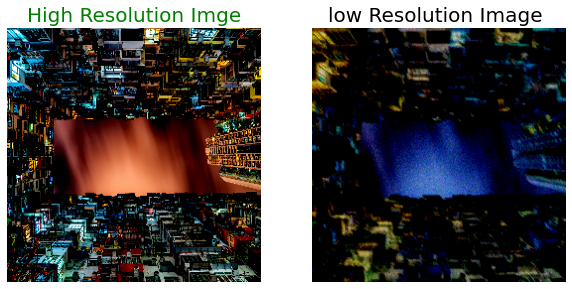

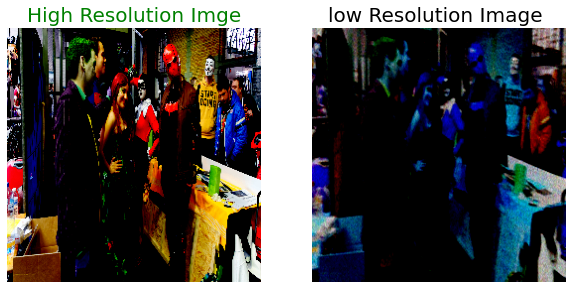

In [6]:
for i in range(3):
    a = np.random.randint(0,300)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.title('High Resolution Imge', color = 'green', fontsize = 20)
    plt.imshow(high_img[a])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('low Resolution Image ', color = 'black', fontsize = 20)
    plt.imshow(low_img[a])
    plt.axis('off')

### Split Dataset Train test and Validation

In [7]:

def get_dataset_partitions_tf(high_img,low_img, train_split=0.6, val_split=0.2, test_split=0.2, shuffle=True):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(high_img)
    
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size) + train_size
    
    train_high_image = high_img[:train_size]
    train_low_image = low_img[:train_size]
    train_high_image = np.reshape(train_high_image,(len(train_high_image),SIZE,SIZE,3))
    train_low_image = np.reshape(train_low_image,(len(train_low_image),SIZE,SIZE,3))

    validation_high_image = high_img[train_size:val_size]
    validation_low_image = low_img[train_size:val_size]
    validation_high_image= np.reshape(validation_high_image,(len(validation_high_image),SIZE,SIZE,3))
    validation_low_image = np.reshape(validation_low_image,(len(validation_low_image),SIZE,SIZE,3))


    test_high_image = high_img[val_size:]
    test_low_image = low_img[val_size:]
    test_high_image= np.reshape(test_high_image,(len(test_high_image),SIZE,SIZE,3))
    test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,3))
    
    return train_high_image,train_low_image, validation_high_image,validation_low_image, test_high_image,test_low_image


train_high_image,train_low_image, validation_high_image,validation_low_image, test_high_image,test_low_image = get_dataset_partitions_tf(high_img,low_img)
  
print("Shape of training images:",train_high_image.shape)
print("Shape of test images:",test_high_image.shape)
print("Shape of validation images:",validation_high_image.shape)

Shape of training images: (480, 256, 256, 3)
Shape of test images: (160, 256, 256, 3)
Shape of validation images: (160, 256, 256, 3)


In [8]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

def model1():
    inputs = layers.Input(shape= [SIZE,SIZE,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    
    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

model = model1()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128, 128, 12  3584        ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 64, 64, 128)  147584      ['sequential[0][0]']             
                                                                                              

In [9]:
def PSNR(y_true, y_pred):
    max_pixel = 1.0
    return (10.0 * K1.log((max_pixel ** 2) / (K1.mean(K1.square(y_pred - y_true), axis=-1)))) / 2.303

def SSIM(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))

In [10]:
# learning rate schedule
def step_decay(epoch):
 initial_lrate = 0.1
 drop = 0.5
 epochs_drop = 10.0
 lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
 return lrate


########################################################################################################################
lrate = LearningRateScheduler(step_decay)
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
#######################################################################################################################
callbacks_list = [lrate, earlystop_callback]

In [11]:
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.1,momentum=0.9), loss = 'mean_absolute_error',
               metrics = [PSNR, 'accuracy', SSIM])

In [12]:
history = model.fit(train_low_image, train_high_image, epochs = 20, batch_size = 1,callbacks=callbacks_list,
          validation_data = (validation_low_image,validation_high_image))

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/20
480/480 [==============================] - 48s 82ms/step - loss: 0.2097 - PSNR: 15.0221 - accuracy: 0.6656 - SSIM: 0.4187 - val_loss: 0.2355 - val_PSNR: 14.5261 - val_accuracy: 0.7663 - val_SSIM: 0.3660 - lr: 0.1000
Epoch 2/20
480/480 [==============================] - 35s 73ms/step - loss: 0.1991 - PSNR: 15.3404 - accuracy: 0.6821 - SSIM: 0.4252 - val_loss: 0.1975 - val_PSNR: 15.7711 - val_accuracy: 0.7594 - val_SSIM: 0.4506 - lr: 0.1000
Epoch 3/20
480/480 [==============================] - 40s 84ms/step - loss: 0.1901 - PSNR: 15.8081 - accuracy: 0.6890 - SSIM: 0.4353 - val_loss: 0.2606 - val_PSNR: 11.6133 - val_accuracy: 0.6816 - val_SSIM: 0.3999 - lr: 0.1000
Epoch 4/20
480/480 [==============================] - 41s 85ms/step - loss: 0.1919 - PSNR: 16.1240 - accuracy: 0.7169 - SSIM: 0.4358 - val_loss: 0.1745 - val_PSNR: 17.8478 - val_accuracy: 0.7766 - val_SSIM: 0.4548 - lr: 0.1000
Epoch 5/20
480/480 [==============================] - 35s 74ms/step - loss: 0.1932 - PSNR: 1

1/1 [==============================] - 0s 31ms/step


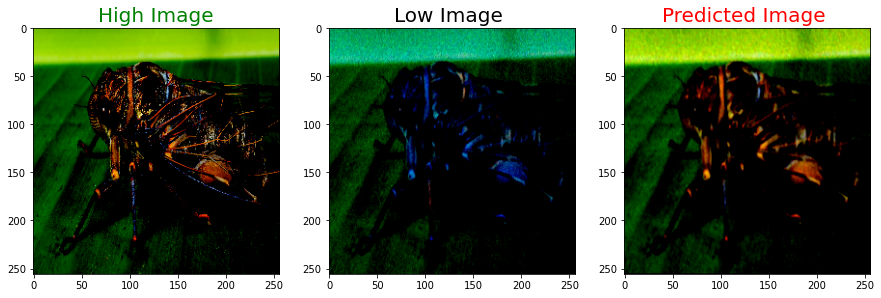

1/1 [==============================] - 0s 42ms/step


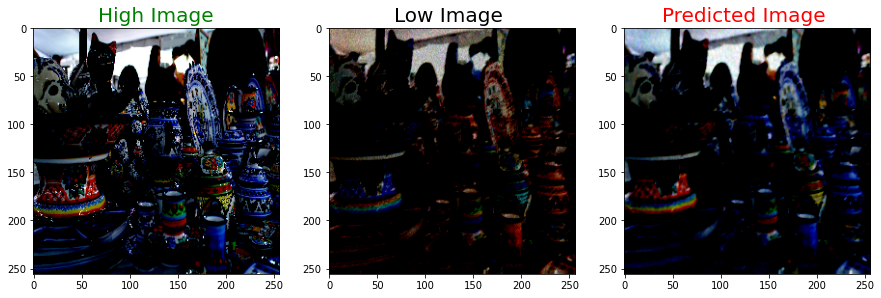

1/1 [==============================] - 0s 44ms/step


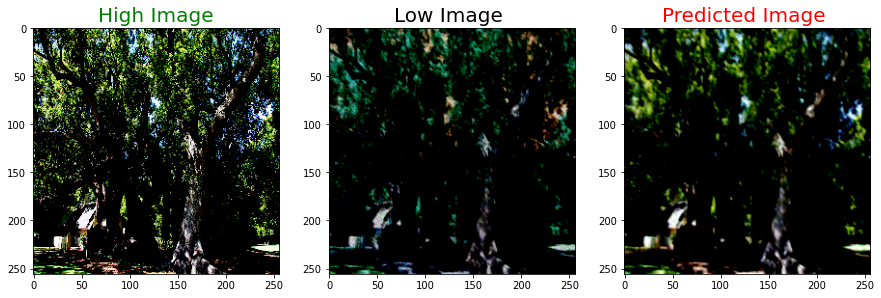

1/1 [==============================] - 0s 41ms/step


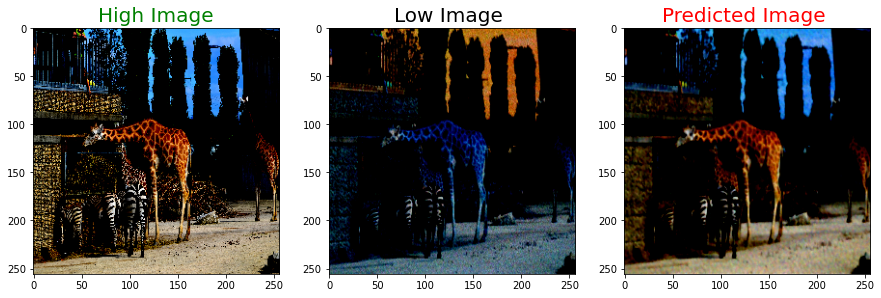

1/1 [==============================] - 0s 46ms/step


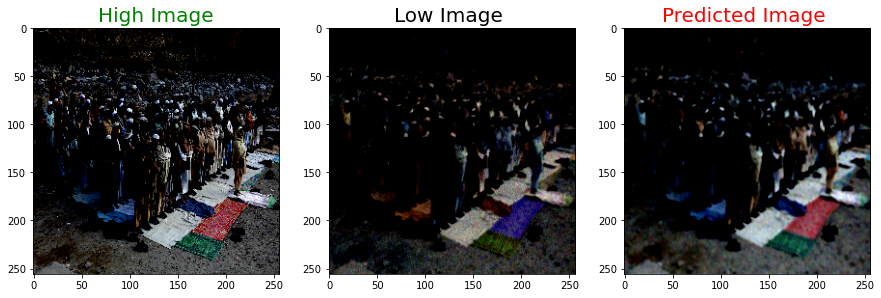

1/1 [==============================] - 0s 54ms/step


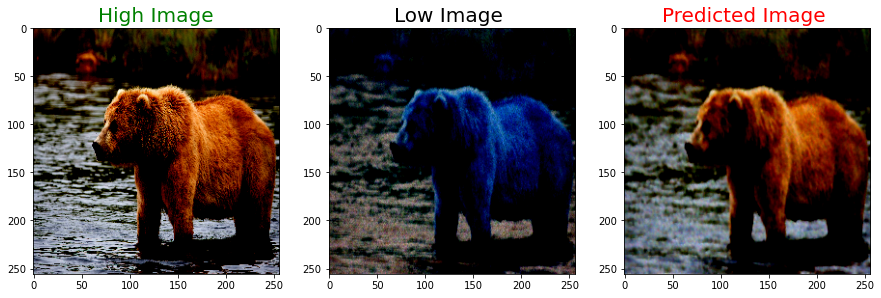

1/1 [==============================] - 0s 49ms/step


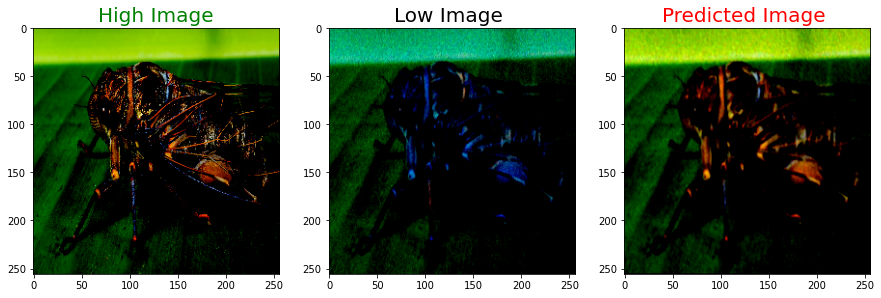

1/1 [==============================] - 0s 45ms/step


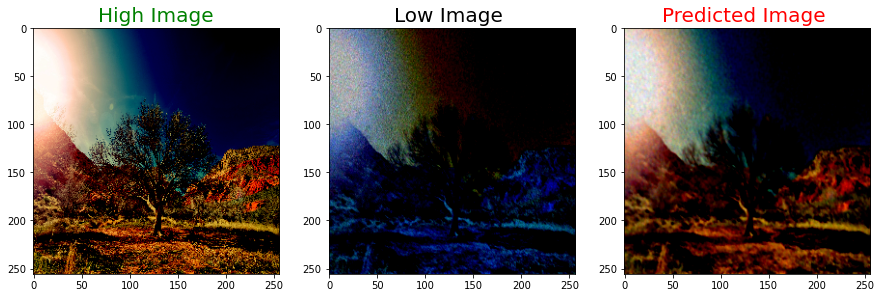

1/1 [==============================] - 0s 42ms/step


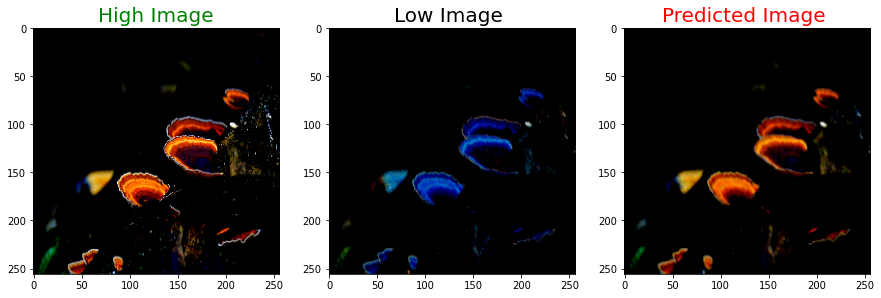

1/1 [==============================] - 0s 37ms/step


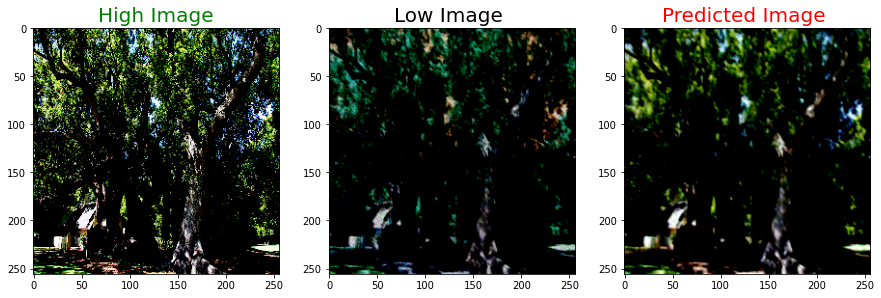

In [13]:
def plot_images(high,low,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high)
    plt.subplot(1,3,2)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for a in range(10):
    i = np.random.randint(0,50)
    
    predicted = np.clip(model.predict(test_low_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_high_image[i],test_low_image[i],predicted)

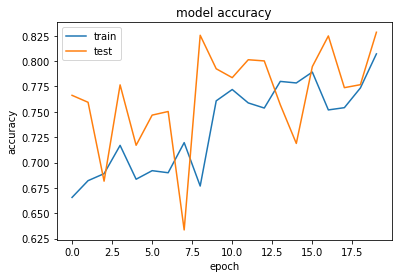

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


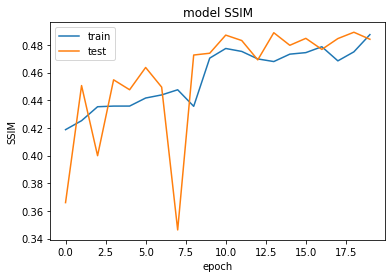

In [15]:
plt.plot(history.history['SSIM'])
plt.plot(history.history['val_SSIM'])
plt.title('model SSIM')
plt.ylabel('SSIM')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

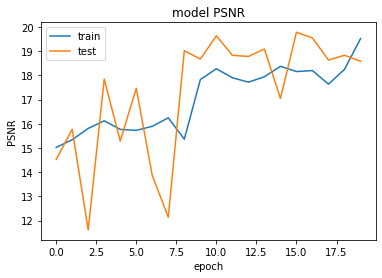

In [16]:
plt.plot(history.history['PSNR'])
plt.plot(history.history['val_PSNR'])
plt.title('model PSNR')
plt.ylabel('PSNR')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

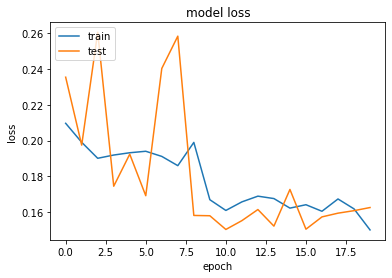

In [17]:

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
model.save("unetSR.h5")

In [19]:
## Low resolution Image
sample_img = []
path = '/content/Sample'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
 
      img = cv2.imread(path + '/'+i,1)

      #resizing image
      img = cv2.resize(img, (SIZE, SIZE))
      img = img.astype('float32') 
      img = (img-127.5)/127.5
      sample_img.append(img_to_array(img))

100%|██████████| 4/4 [00:00<00:00, 53.08it/s]


In [ ]:
predicted = np.clip(model.predict(test_low_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
plot_images(test_high_image[i],test_low_image[i],predicted)

In [29]:
def mse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err
def compare_images(imageA, imageB, title):
	# compute the mean squared error and structural similarity
	# index for the images
	m = mse(imageA, imageB)
	s = ssim(imageA, imageB,multichannel=True)
	# setup the figure
	fig = plt.figure(title)
	plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s))
	# show first image
	ax = fig.add_subplot(1, 2, 1)
	plt.imshow(imageA, cmap = plt.cm.gray)
	plt.axis("off")
	# show the second image
	ax = fig.add_subplot(1, 2, 2)
	plt.imshow(imageB, cmap = plt.cm.gray)
	plt.axis("off")
	# show the images
	plt.show()

1/1 [==============================] - 0s 73ms/step


/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


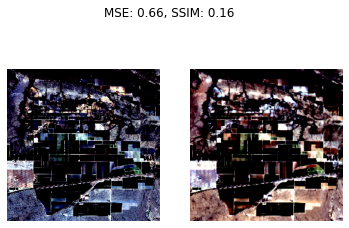

1/1 [==============================] - 0s 73ms/step


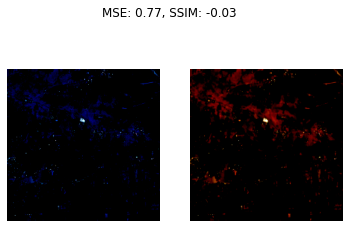

1/1 [==============================] - 0s 53ms/step


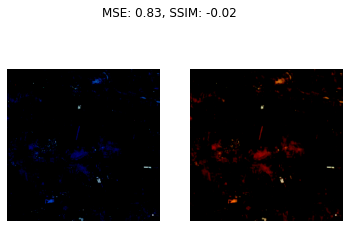

1/1 [==============================] - 0s 57ms/step


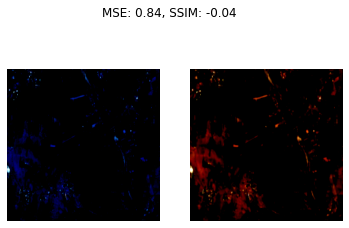

In [32]:
for i in range(4):
      predicted = np.clip(model.predict(sample_img[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
      compare_images(sample_img[i], predicted, "Original vs. Original")

# for the next steps we can go with RUNET or SRGAN